#### Classification | Model

# Predicting Heart Disease  

## Classification Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exporatory Data Analysis](#3)<br/>
4. [Baselining](#4)<br/>
5. [Validation and Testing](#5)<br/>
6. [Model Iterations](#6) <br/>
7. [Model Selection ](#7)<br/>



In [ ]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) 

from ipywidgets import interactive, FloatSlider
from plotly.subplots import make_subplots
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.ensemble import AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression ,LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC ,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

iris_dataset = datasets.load_iris()


## 1 | Research Design<a id='1'></a> 

* **Reserach Question:** How might we predict which patients are at high risk of heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** [Recall](#3c) and [ROC AUC](#3c)

#### [Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<a id='1a'></a>
_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors_
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

[back to top](#top)

## 2 | [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)<a id='2'></a>  


In [2]:
# load clean and transformed dataframes from mvp 
heart_disease_df = pd.read_csv('heart_disease_df.csv')
heart_disease_df_map = pd.read_csv('heart_disease_df_map.csv') 


In [ ]:
# clean df
heart_disease_df.head(3)


In [ ]:
# mapped categorical variables to numberical values 
heart_disease_df_map.head(3)


[back to top](#top)

## 3 | Exporatory Data Analysis<a id='3'></a> 

#### Using the dataframe `heart_disease_df_map` with mapped variables for EDA and modeling.  

### 3.1 Explore and summarize data<a id='31'></a> 

In [114]:
# dataframe info
heart_disease_df_map.info()

# no missing data, all dtypes are numerical 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   behavior_activity  319795 non-null  int64  
 1   behavior_alcohol   319795 non-null  int64  
 2   behavior_sleep     319795 non-null  float64
 3   behavior_tobacco   319795 non-null  int64  
 4   demg_age           319795 non-null  int64  
 5   demg_gender        319795 non-null  int64  
 6   demg_race          319795 non-null  int64  
 7   disease_asthma     319795 non-null  int64  
 8   disease_diabetes   319795 non-null  int64  
 9   disease_kidney     319795 non-null  int64  
 10  disease_skin       319795 non-null  int64  
 11  disease_stroke     319795 non-null  int64  
 12  health_bmi         319795 non-null  float64
 13  health_general     319795 non-null  int64  
 14  health_mental      319795 non-null  float64
 15  health_mobility    319795 non-null  int64  
 16  he

[back to top](#top)

### 3.2 Classification viability<a id='32'></a> 

In [109]:
# descriptive statistics
heart_disease_df_map.describe().T.style.background_gradient(cmap='Blues')


,count,mean,std,min,25%,50%,75%,max
behavior_activity,319795.000000,0.775362,0.417344,0.000000,1.000000,1.000000,1.000000,1.000000
behavior_alcohol,319795.000000,0.068097,0.251912,0.000000,0.000000,0.000000,0.000000,1.000000
behavior_sleep,319795.000000,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000
behavior_tobacco,319795.000000,0.412477,0.492281,0.000000,0.000000,0.000000,1.000000,1.000000
demg_age,319795.000000,52.440945,18.069747,18.000000,40.000000,55.000000,65.000000,80.000000
demg_gender,319795.000000,1.475273,0.499389,1.000000,1.000000,1.000000,2.000000,2.000000
demg_race,319795.000000,5.396742,1.212208,1.000000,6.000000,6.000000,6.000000,6.000000
disease_asthma,319795.000000,0.134061,0.340718,0.000000,0.000000,0.000000,0.000000,1.000000
disease_diabetes,319795.000000,0.207205,0.554528,0.000000,0.000000,0.000000,0.000000,3.000000
disease_kidney,319795.000000,0.036833,0.188352,0.000000,0.000000,0.000000,0.000000,1.000000


In [110]:
# correlation matrix
heart_disease_df_map.corr().style.background_gradient(cmap='Blues')


,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease,behaviors,demographics,disease,measures
behavior_activity,1.000000,0.017487,0.003849,-0.097174,-0.121465,0.048247,0.056767,-0.041526,-0.097539,-0.081827,-0.001328,-0.079455,-0.150616,0.281249,-0.095808,-0.278524,-0.232283,-0.100030,0.240382,-0.114984,-0.121318,-0.232098
behavior_alcohol,0.017487,1.000000,-0.005065,0.111768,-0.058837,0.004200,0.036702,-0.002202,-0.042695,-0.028280,-0.005702,-0.019858,-0.038816,0.029780,0.051282,-0.035328,-0.017254,-0.032080,0.194463,-0.055611,-0.043052,0.002955
behavior_sleep,0.003849,-0.005065,1.000000,-0.030336,0.103071,-0.015704,0.035889,-0.048245,-0.005166,0.006238,0.041266,0.011900,-0.051822,0.063071,-0.119717,-0.022216,-0.061387,0.008327,0.900485,0.103835,-0.004723,-0.117913
behavior_tobacco,-0.097174,0.111768,-0.030336,1.000000,0.130384,0.085052,0.065499,0.024149,0.038993,0.034920,0.033977,0.061226,0.023118,-0.174717,0.085157,0.120074,0.115352,0.107764,0.276416,0.135549,0.070918,0.110274
demg_age,-0.121465,-0.058837,0.103071,0.130384,1.000000,-0.067682,0.162777,-0.058235,0.154070,0.122697,0.262208,0.137280,-0.001740,-0.188236,-0.155455,0.242552,0.110789,0.232325,0.092926,0.997431,0.233773,-0.033017
demg_gender,0.048247,0.004200,-0.015704,0.085052,-0.067682,1.000000,0.018855,-0.069191,-0.018350,-0.009084,0.013434,-0.003091,0.026940,0.025947,-0.100058,-0.068860,-0.040904,0.070040,0.025665,-0.038334,-0.039320,-0.065215
demg_race,0.056767,0.036702,0.035889,0.065499,0.162777,0.018855,1.000000,-0.017975,-0.056252,0.003709,0.134780,-0.003956,-0.037424,0.057986,-0.014491,-0.015831,-0.000847,0.034854,0.073943,0.227730,0.002224,-0.021002
disease_asthma,-0.041526,-0.002202,-0.048245,0.024149,-0.058235,-0.069191,-0.017975,1.000000,0.044136,0.039707,-0.000396,0.038866,0.092345,-0.137342,0.114008,0.103222,0.117907,0.041444,-0.047690,-0.060647,0.464788,0.160077
disease_diabetes,-0.097539,-0.042695,-0.005166,0.038993,0.154070,-0.018350,-0.056252,0.044136,1.000000,0.095186,0.024113,0.072476,0.163437,-0.204278,0.029970,0.152876,0.111644,0.118281,-0.025141,0.148064,0.744122,0.138095
disease_kidney,-0.081827,-0.028280,0.006238,0.034920,0.122697,-0.009084,0.003709,0.039707,0.095186,1.000000,0.061816,0.091167,0.050768,-0.174642,0.037281,0.153064,0.142197,0.145197,-0.009583,0.121282,0.354756,0.111638


[back to top](#top)

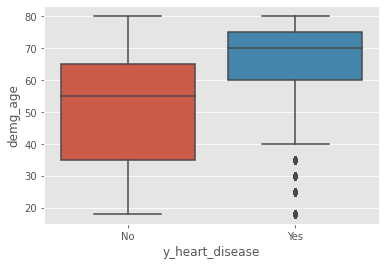

In [5]:
# target vs age
ax = sns.boxplot(x='y_heart_disease', y='demg_age', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


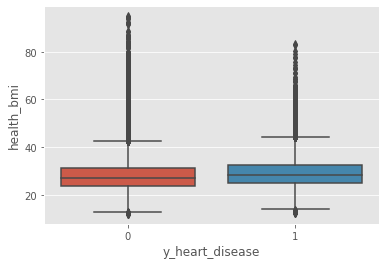

In [6]:
# target vs mobility
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


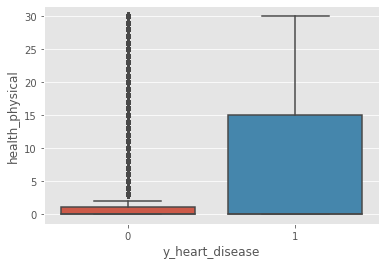

In [7]:
# target vs physical health
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df_map)
ax.set_xticklabels(['No', 'Yes']);


In [115]:
# target distribution
print('Positives/Negatives Ratio:', round(27373/292422, 4) * 100, '%')
print(heart_disease_df['y_heart_disease'].value_counts())


Positives/Negatives Ratio: 9.36 %
No     292422
Yes     27373
Name: y_heart_disease, dtype: int64


### 3.3 Classification metrics<a id='33'></a> 

* **Recall** to maximize on patients who are true positives for heart disease.
* **ROC AUC** to identify high vs low risk patients. 

[back to top](#top)

## 4 | Baseline<a id='4'></a> 

#### Logistic regression with three features based on correlation matrix.

In [ ]:
# separate target from features based on the correlation matrix
y_base = heart_disease_df_map['y_heart_disease'] 
X_base = heart_disease_df_map.loc[:, [
#     'behavior_activity', 
#     'behavior_alcohol', 
#     'behavior_sleep',
#     'behavior_tobacco',
    'demg_age',
#     'demg_gender', 
#     'demg_race',
#     'disease_asthma', 
#     'disease_diabetes', 
#     'disease_kidney', 
#     'disease_skin', 
#     'disease_stroke', 
#     'health_bmi', 
#     'health_general', 
#     'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split baseline data test/train/validate
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, 
                                                    y_base, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train_base, X_validate_base, y_train_base, y_validate_base = train_test_split(X_train_base, y_train_base, 
                                                            test_size = .25, random_state = 42)

# scale baseline X train/test
scaler_base = StandardScaler()
X_train_scaled_base = scaler_base.fit_transform(X_train_base)
X_test_scaled_base = scaler_base.transform(X_test_base)
X_validate_scaled_base = scaler_base.transform(X_validate_base)


In [ ]:
# baseline logistic regression X train scaled & y train
log_reg_base = LogisticRegression().fit(X_train_scaled_base, y_train_base)

# baseline predict on X_validate_scaled_m 
y_pred_base = logreg_base.predict(X_validate_scaled_base) 

# score on X_test_scaled and y_test
print("Baseline logistic regression recall:", round(
    recall_score(log_reg_base.predict(X_validate_scaled_base), y_validate_base), 4))

print("Baseline logistic regression ROC AUC score (val):",  round(
    roc_auc_score(y_validate_base, log_reg_base.predict_proba(X_validate_scaled_base)[:,1]), 4))



## 5 | Validation<a id='5'></a>

#### Validation and testing scheme to use in [model selection](#7). 

In [137]:
# separate target from features 
y = heart_disease_df_map['y_heart_disease'] 
X = heart_disease_df_map.loc[:, [
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split data test/train/validate
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, 
                                                            test_size = .25, random_state = 42)

# scale X train/test/validate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validate_scaled = scaler.transform(X_validate)


[back to top](#top)

## 6 | Model Iterations <a id='6'></a> 

- Starting from the baseline and in an iterative, validated loop ask: 
    - Do you need more complexity or less (underfitting vs. overfitting)? 
    - Do you need a fancier model (nonlinear, additional feature engineering / transformations)? 
    - If you need more complexity, try tree-based models such as random forest or gradient boosted trees. 
    - Are you overfitting and need to make your model more conservative by removing features or using regularization? - Hopefully you can quickly acquire an understanding of which direction you need to go in from your baseline and early modeling results, then make more fine-tuned changes as you go.


- The impact of model choices should be consistently measured against the same validation data as in part 3, using your relevant classification performance metrics such as F1 or ROC AUC. 


[back to top](#top)

### 6.1 k-Nearest Neighbors<a id='61'></a> 

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
# print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
# print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))



[back to top](#top)

### 6.2 Logistic Regression<a id='62'></a> 

In [97]:
log_reg = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_validate_scaled) 

print("Logistic regression recall score (val):", round(
    recall_score(log_reg.predict(X_validate_scaled), y_validate), 4))
print("Logistic regression ROC AUC score (val):",  round(
    roc_auc_score(y_validate, log_reg.predict_proba(X_validate_scaled)[:,1]), 4))



Logistic regression recall score (val): 0.5195
Logistic regression ROC AUC score (val): 0.8411


Logistic regression maybe [model winner](#7), recall score improved from [baseline](#4).<br/>


[back to top](#top)

### 6.3 Decision Trees<a id='63'></a> 

Decision tree (depth=2) recall (val): 0.0


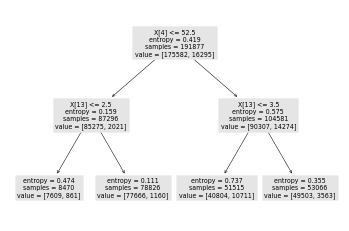

In [98]:
# tree max depth 2
dt = DecisionTreeClassifier(max_depth=2,criterion="entropy")
dt.fit(X_train, y_train)
y_pred = dt.predict(X_validate)

print("Decision tree (depth=2) recall (val):", round(
    recall_score(dt.predict(X_validate), y_validate), 4))
tree.plot_tree(dt);

Decision tree (depth=4) recall score (val): 0.0


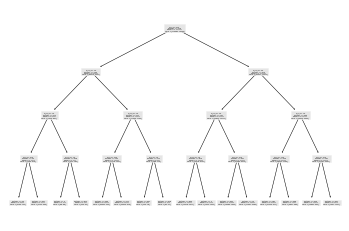

In [100]:
# tree max depth 4
dt = DecisionTreeClassifier(max_depth=4,criterion="entropy")
dt.fit(X_train, y_train)
y_pred = dt.predict(X_validate)
print("Decision tree (depth=4) recall score (val):", round(
    recall_score(dt.predict(X_validate), y_validate), 4))
tree.plot_tree(dt);

### 6.4 Random Forests <a id='64'></a> 

In [102]:
forest = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = forest.predict(X_validate)
print("Random forestes recall score (val):", round(
    recall_score(forest.predict(X_validate), y_validate), 4))


Random forestes recall score (val): 0.3642


Random forest model performs worse than [logistic regression](#6b). 

[back to top](#top)

### 6.5 Gradient Boosted Trees: xgboost<a id='65'></a> 

In [ ]:
### code block

[back to top](#top)

### 6.6 Ensemble<a id='66'></a> 

In [ ]:
### code block

[back to top](#top)

### 6.7. Naive Bayes<a id='67'></a> 

In [103]:
# BernoulliNB() 
nb = BernoulliNB().fit(X_train_scaled, y_train)
y_predict_nb = nb.predict(X_validate_scaled) 
print("Bernoulli NB recall score (val):", round(
    recall_score(nb.predict(X_validate), y_validate), 4))

Bernoulli NB recall score (val): 0.3161


[back to top](#top)

## Feature Engineering <a id='6h'></a> 

Create features based on four groups in [data dictionary](#1a): behaviors, demographics, disease, and health measures. 

In [83]:
# 1 behaviors = phyiscial activity days/month, sleep time hrs/day,  alcohol, and tobacco use
heart_disease_df_map['behaviors'] = (
    heart_disease_df_map['behavior_activity'] +
    heart_disease_df_map['behavior_alcohol'] +  
    heart_disease_df_map['behavior_sleep'] +
    heart_disease_df_map['behavior_tobacco'])

# 2 demographics = age, gender, race
heart_disease_df_map['demographics'] = (
    heart_disease_df_map['demg_age'] +
    heart_disease_df_map['demg_gender'] +  
    heart_disease_df_map['demg_race'])

# 3 disease = asthma, diabetes, kidney, skin cancer, stroke
heart_disease_df_map['disease'] = (
    heart_disease_df_map['disease_asthma'] +
    heart_disease_df_map['disease_diabetes'] +  
    heart_disease_df_map['disease_kidney'] +
    heart_disease_df_map['disease_skin'] +
    heart_disease_df_map['disease_stroke'])

# 4 health (measures) = asthma, diabetes, kidney, skin cancer, stroke
heart_disease_df_map['measures'] = (
    heart_disease_df_map['health_bmi'] +
    heart_disease_df_map['health_general'] +  
    heart_disease_df_map['health_mental'] +
    heart_disease_df_map['health_mobility'] +
    heart_disease_df_map['health_physical'])

heart_disease_df_map.columns


Index(['behavior_activity', 'behavior_alcohol', 'behavior_sleep',
       'behavior_tobacco', 'demg_age', 'demg_gender', 'demg_race',
       'disease_asthma', 'disease_diabetes', 'disease_kidney', 'disease_skin',
       'disease_stroke', 'health_bmi', 'health_general', 'health_mental',
       'health_mobility', 'health_physical', 'y_heart_disease', 'behaviors',
       'demographics', 'disease', 'measures'],
      dtype='object')

### Logistic regression, only engineered features<a id='6h1'></a> 

In [84]:
# separate target from engineered features 
y_f = heart_disease_df_map['y_heart_disease'] 
X_f = heart_disease_df_map.loc[:, ['behaviors', 
                                   'demographics', 
                                   'disease', 
                                   'measures']]

# split data test/train/validate
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, 
                                                    y_f, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train_f, X_validate_f, y_train_f, y_validate_f = train_test_split(X_train_f, y_train_f, 
                                                            test_size = .25, random_state = 42)
# scale X train/test/validate
scaler = StandardScaler()
X_train_f_scaled = scaler.fit_transform(X_train_f)
X_test_f_scaled = scaler.transform(X_test_f)
X_validate_f_scaled = scaler.transform(X_validate_f)


In [85]:
# logistic regression with only engineered features
log_reg_f = LogisticRegression().fit(X_train_f_scaled, y_train_f)
y_pred_f = log_reg_f.predict(X_validate_f_scaled) 
print("Logistic regression only engineered features recall:", round(
    recall_score(log_reg_f.predict(X_validate_f_scaled), y_validate_f), 4))


Logistic regression only engineered features recall: 0.3895


Logistic regression with only engineered features performs worse than first iteration of [logistic regression](#6b). 

[back to top](#top)

### Logistic regression, original + engineered features<a id='6h2'></a> 

In [86]:
# separate target from features 
y_ff = heart_disease_df_map['y_heart_disease'] 
X_ff = heart_disease_df_map.loc[:, [
    'behaviors', 
    'demographics', 
    'disease', 
    'measures',
    'behavior_activity', 
    'behavior_alcohol', 
    'behavior_sleep',
    'behavior_tobacco',
    'demg_age',
    'demg_gender', 
    'demg_race',
    'disease_asthma', 
    'disease_diabetes', 
    'disease_kidney', 
    'disease_skin', 
    'disease_stroke', 
    'health_bmi', 
    'health_general', 
    'health_mental',
    'health_mobility', 
    'health_physical'
    ]]

# split data test/train/validate
X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(X_ff, 
                                                    y_ff, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train_ff, X_validate_ff, y_train_ff, y_validate_ff = train_test_split(X_train_ff, y_train_ff, 
                                                            test_size = .25, random_state = 42)

# Scale X train/test/validate
scaler = StandardScaler()
X_train_ff_scaled = scaler.fit_transform(X_train_ff)
X_test_ff_scaled = scaler.transform(X_test_ff)
X_validate_ff_scaled = scaler.transform(X_validate_ff)


In [87]:
# Logistic regression with engineered  +  feat eng
log_reg_ff = LogisticRegression().fit(X_train_ff_scaled, y_train_ff)
y_pred_ff = log_reg_ff.predict(X_validate_ff_scaled) 
print("Logistic regression recall:", round(
    recall_score(log_reg_ff.predict(X_validate_ff_scaled), y_validate_ff), 4))


Logistic regression recall: 0.52


Logistic regression with original + engineered features performs better than [logistic regression model with only engineered features](#6h1) and the same as the first iteration of [logistic regression](#6b). 

[back to top](#top)

## Class Imblance Handling <a id='6g'></a> 

In [22]:
# target imbalance
heart_disease_df_map.y_heart_disease.value_counts()

0    292422
1     27373
Name: y_heart_disease, dtype: int64

In [ ]:
# resample?

In [ ]:
# class_weight adjustments
# _sklearn fbeta score – f2 or f3 to upweight recall_

In [ ]:
# decision threshold to max recall

[back to top](#top)

## 7 | Model Selection<a id='7'></a> 

#### Model winner: [logistic regression](#6b), validate and test using [scheme](#5) presented above. 

### 7.1 Finalize and test<a id='71'></a> 

- When satisfied with the results of your tuning in _Model Iterations_, establish your final model choices:
        - features, 
        - preprocessing, 
        - imbalance handling strategy, and 
        - hyperparameters
    - retrain this model on all training + validation data. 
- Make predictions on the test data and score these predictions, reporting this score as your estimate of the model's generalization performance.


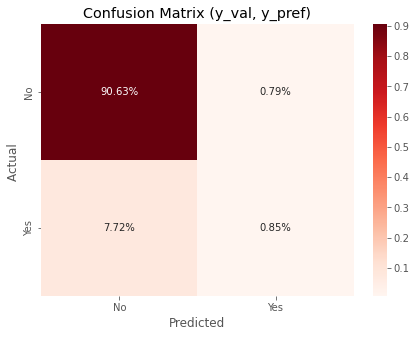

In [49]:
# Confusion matrix on y_validate, y_pred_lg
cm = confusion_matrix(y_validate, y_pred_lg)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Reds')

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual ')

ax.xaxis.set_ticklabels(['No','Yes'])
ax.yaxis.set_ticklabels(['No','Yes'])
plt.title('Confusion Matrix (y_val, y_pred)')

# plt.show()
plt.savefig("confusion-matrix.svg")
plt.savefig("confusion-matrix.png")
plt.savefig("confusion-matrix.jpeg");


In [90]:
# classification report on y_validate/predict
print(classification_report(y_validate_base, 
                            y_pred_base, 
                            target_names=['no heart disease', 'yes heart disease']))



                   precision    recall  f1-score   support

 no heart disease       0.92      1.00      0.95     58473
yes heart disease       0.36      0.02      0.04      5486

         accuracy                           0.91     63959
        macro avg       0.64      0.51      0.50     63959
     weighted avg       0.87      0.91      0.88     63959



ROC AUC score =  0.8411422086561615


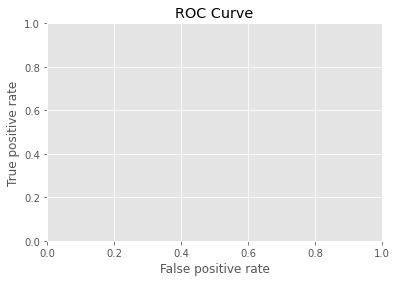

In [145]:
# ROC curve 1
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve');
print("ROC AUC score = ", roc_auc_score(y_validate, log_reg.predict_proba(X_validate_scaled)[:,1]))


In [147]:
# ROC curve 2
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, lm.predict_proba(X_test)[:,1]))

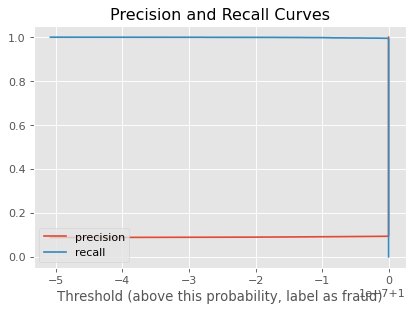

In [148]:
# precision and recall curves
# probabilities to make a curve showing us how recall and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(
    y_test, log_reg.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

### 7.2 Interpret<a id='72'></a> 


**Interpret.** 
- Extract and study your final model coefficients or feature importances. Are there any interesting or unexpected takeaways? 
- How do the model coefficients/importances align with your intuition and domain knowledge about the problem? 
- Be careful about complicating factors in interpretation such as differing feature scales and multicollinearity.


[back to top](#top)